## Class definitions and util functions

In [5]:
!pip install dataclasses

from dataclasses import dataclass
from typing import Literal, Any
from collections import defaultdict


@dataclass
class Feria:
    cod_comuna: str
    comuna: str
    dias: list[int]
    cantidad_puestos: int


@dataclass
class Producto:
    id: int
    nombre: str
    meses_siembra: list[int]
    meses_venta: list[int]
    dias_cosecha: float
    unidad: Literal["unidades", "kilos"]
    unit_ha: float
    volumen_feriante: float
    volumen_un_consumidor: float
    prob_consumir: float
    costo_ha: float
    prob_compra_feriante: float
    oc: tuple[float, float, float]
    sequias: tuple[float, float, float]
    heladas: tuple[float, float, float]
    plagas: tuple[float, float, float]
    precios_mes: list[float]
    precio_consumidor: float

@dataclass
class Solution:
    items: list[int]
    data: list[Any]

    def get_partitions(self) -> dict[int, list[Any]]:
        partitions = defaultdict(list)
        idx = 0
        while idx < len(self.items):
            partitions[self.items[idx]].append(self.data[idx])
            idx += 1
        return partitions

            



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [6]:
import json

def read_ferias(file_dir: str) -> list[Feria]:
    with open(file_dir, 'r') as file:
        data = json.load(file)
    ferias = [Feria(**feria) for feria in data]
    return ferias

def read_productos(file_dir: str) -> list[Producto]:
    with open(file_dir, 'r') as file:
        data = json.load(file)
    items = [{"unit_ha" if key == "unit/ha" else key : val for key, val in item.items()} for item in data]
    productos = [Producto(**item) for item in items]
    return productos

## Main algorithm and helper functions

### Main implementation of Simulated Annealing

In [91]:
from typing import Any, Callable
from math import sqrt
import random
import math

def simulated_annealing_partitioning(
    items: list[Any], 
    n: int,
    f: Callable[..., Any],
    find_neighbour: Callable[..., Any],
    init_temp: float = 1_000,
    temp_threshold: float = 1e-3,
    cooling_rate: float = 0.99,
    debug: bool = False,
    **kwargs,
) -> tuple[Solution, float, list[float], list[float]]:
    """
    Implementación de Simulated Annealing para maximizar una función objetivo dada.
    Params:
        - items: elementos a particionar
        - n: número de particiones a generar
        - f: función objetivo a ser maximizada.
        - find_neighbour: función para encontrar el siguiente vecino a evaluar
        - temp_threshold: umbral para enfriamiento del recocido
        - cooling_rate: tasa de enfriamiento. Reduce geométricamente la temperatura.
    """
    # Para histórico de puntajes
    best_score_history = []
    current_score_history = []
    
    
    # Generamos solución inicial de forma aleatoria
    sol = Solution(items=[random.randint(0, n - 1) for item in items], data=items)
    sol_score = f(sol, **kwargs)
    best_score = sol_score
    best_sol = sol
    temp = init_temp
    cont = 0
    while temp > temp_threshold:
        neighbour = find_neighbour(sol, f, **kwargs)
        new_score = f(neighbour, **kwargs)
        delta = new_score - sol_score
        if delta > 0 or random.uniform(0, 1) < math.exp(
            delta / temp
        ):
            sol = neighbour
            sol_score = new_score

            if sol_score > best_score:
                best_score = sol_score
                best_sol = sol
        temp *= cooling_rate
        best_score_history.append(best_score)
        current_score_history.append(new_score)
        if debug:
            print(f"best score: {best_score} - current_score: {score} - new_score: {new_score} - temp: {temp}")

        cont += 1
        
    return best_sol, best_score, best_score_history, current_score_history
    

### Neighbourhood search functions

In [70]:
def find_next_best_neighbour(
    sol: Solution, f: Callable[..., Any], op: Callable[..., Any], r: int = 1, n_iter: int = 100, **kwargs
) -> Solution:
    """
    Función que implementa procedimiento para encontrar el siguiente mejor vecino.
    Params:
        - sol: Solución que corresponde al punto de inicio de la búsqueda
        - f: Función objetivo para evaluar la calidad de la solución
        - r: Cantidad de veces que se aplica el operador entre vecinos evaluados. Un valor más grande significa que los vecinos evaluados serán más distintos entre sí, mientras que un valor más pequeño evaluará vecinos más cercanos o similares.
        - n_iter: Cantidad máxima de iteraciones hasta detener la búsqueda
        - op: Operador para explorar la vecindad
    """
    score = f(sol, **kwargs)
    new_sol = sol_step = sol 
    i = 0
    while i < n_iter:
        for _ in range(0, r):
            new_sol = op(new_sol, **kwargs)
        new_score = f(new_sol, **kwargs)
        if new_score >= score:
            return new_sol
        sol_step = new_sol
        i = i + 1
        
    return sol


def adaptive_next_neighbour(
    sol: Solution, f: Callable, g: Callable[list, list], r: int = 1, **kwargs
) -> Solution:
    """
    Función que encuentra el siguiente vecino en función de la distribución actual de 
    carga de cómputo. Usa una función greedy g() para determinar la carga relativa de cada
    partición, para luego intercambiar r elementos de la partición con más carga con la 
    con menor carga.
    """
    # Repetimos el proceso r veces
    for _ in range(r):
        # Obtenemos las particiones
        partitions = sol.get_partitions()
        # Determinamos las particiones con mayor y menor carga
        partitions_score = {k: g(items) for k, items in partitions.items()}
        min_part = min(partitions_score.items(), key=lambda x:x[1])
        max_part = max(partitions_score.items(), key=lambda x:x[1])
        # print(f"min part: {min_part}  -  max part: {max_part}")

        # Decidimos qué instancias intercambiaremos. Esta versión elige al azar
        item_1 = random.randint(0, len(partitions[min_part[0]]) - 1)
        item_2 = random.randint(0, len(partitions[max_part[0]]) - 1)

        obj_1 = partitions[min_part[0]][item_1]
        obj_2 = partitions[max_part[0]][item_2]

        # Modificamos la solución
        for idx, obj in enumerate(sol.data):
            if obj == obj_1:
                sol.items[idx] = max_part[0]
            elif obj == obj_2: 
                sol.items[idx] = min_part[0]
    return sol


def shaker_operator(
    sol: Solution
) -> Solution:
    """
    Intercambia dos elementos al azar de una solución
    """
    # Elegimos dos elementos al azar
    item_1 = random.randint(0, len(sol.items) - 1)
    item_2 = random.randint(0, len(sol.items) - 1)
    # print(f"item 1: {item_1} - item 2: {item_2}")
    # Los intercambiamos
    aux = sol.items[item_1]
    sol.items[item_1] = sol.items[item_2]
    sol.items[item_2] = aux
    
    return sol




### Product objective functions

In [44]:
def productos_naive_objective_function(sol: Solution, **_) -> float:
    """
    Función similar a lo implementado en la primera versión del particionador.
    Encuentra un centroide que representa la distribución ideal por mes del año y 
    calcula la distancia con respecto a ese vector.
    """
    
    # Obtenemos las particiones
    partitions = sol.get_partitions()

    num_items = len(sol.data)

    # Calculamos centroide  
    centroid = [0] * 12

    for prod in sol.data:
        for mes in prod.meses_venta:
            centroid[mes] += 1
    
    # Normalizamos el vector
    centroid = list(map(lambda x: x / num_items, centroid))

    # Calculamos el vector para cada partición y obtenemos la diferencia
    diff = 0.0
    for partition in partitions.values():
        
        vector = [0] * 12
        for prod in partition:
            for mes in prod.meses_venta:
                vector[mes] += 1

        vector = list(map(lambda x: x / num_items, vector))
        
        diff += sum(map(lambda x, y: abs(x - y), vector, centroid))

    return  - diff
        
    
    
def productos_weighted_naive_objective_function(sol: Solution, **_) -> float:
    """
    Similar a la versión anterior, pero pondera por la probabilidad de compra
    de feriante - que debería ser un valor proxy para la cantidad de trabajo asociado a 
    ese producto.
    """
    
    # Obtenemos las particiones
    partitions = sol.get_partitions()

    # Calculamos centroide inicial
    centroid = [0] * 12
    for prod in sol.data:
        for mes in prod.meses_venta:
            centroid[mes] += prod.prob_compra_feriante

    # Calculamos el vector para cada partición y calculamos la diferencia
    diff = 0.0
    for partition in partitions.values():
        vector = [prod.prob_compra_feriante for mes in prod.meses_venta for prod in partition]
        diff += sum(map(lambda x, y: (x - y)**2, vector, centroid))
    return -sqrt(diff)


def productos_penalized_weighted_obj_function(sol: Solution, penalty: float = 0.1, **kwargs) -> float:
    """
    Esta implementación abandona la idea de un centroide ideal.
    Más bien, se intenta maximizar la cantidad de cómputo de cada partición.
    Además, si una partición no tiene cómputo para algún mes de la simulación, 
    se le penaliza.
    """
    
    # Obtenemos las particiones
    partitions = sol.get_partitions()

    score = 0.0
    # Recorremos las particiones y obtenemos sus puntajes respectivos
    for partition in partitions.values():
        vector = [prod.prob_compra_feriante for prod in partition for mes in prod.meses_venta ]
        for month in vector:
            score += month if month else -penalty
    return score

def producto_partition_greedy_function(partition: list[Producto], penalty: float = 0.1) -> float:
    months = [0.0] * 12
    score = 0.0
    for prod in partition:
        for active_month in prod.meses_venta:
            months[active_month] += prod.prob_compra_feriante
    for month in months:
        score += month if month else -penalty
        
    return score
        

### Ferias objective functions

In [90]:
def feria_penalized_objective_function(sol: Solution, penalty: float = 200, **_):
    partitions = sol.get_partitions()
    score = 0.0
    # Recorremos las particiones y obtenemos sus puntajes respectivos
    for partition in partitions.values():
        vector = [0.0] * 7
        for feria in partition:
            for dia in feria.dias:
                vector[dia] += feria.cantidad_puestos
        for dia in vector:
            score += dia if dia else -penalty
    return score



## Executions and plotting

In [22]:

ferias = read_ferias('../inputs/ferias.json')

productos = read_productos('../inputs/prods.json')
# Registramos las funciones objetivo a evaluar
obj_functions = [
    ('naive', productos_naive_objective_function),
    ('weighted', productos_weighted_naive_objective_function),
    ('penalized_weighted', productos_penalized_weighted_obj_function),
]


In [65]:

eval_data = {}

for name, func in obj_functions:
    sol, score, best_score_history, current_score_history = simulated_annealing_partitioning(
        items=productos,
        n = 8,
        f = productos_weighted_naive_objective_function,
        find_neighbour=find_next_best_neighbour,
        op=shaker_operator,
        r=5,
        cooling_rate=0.999
    )

    eval_data.update({name: {"best_score": score, "best_score_history": best_score_history, "solution": sol, "current_score_history": current_score_history}})
    

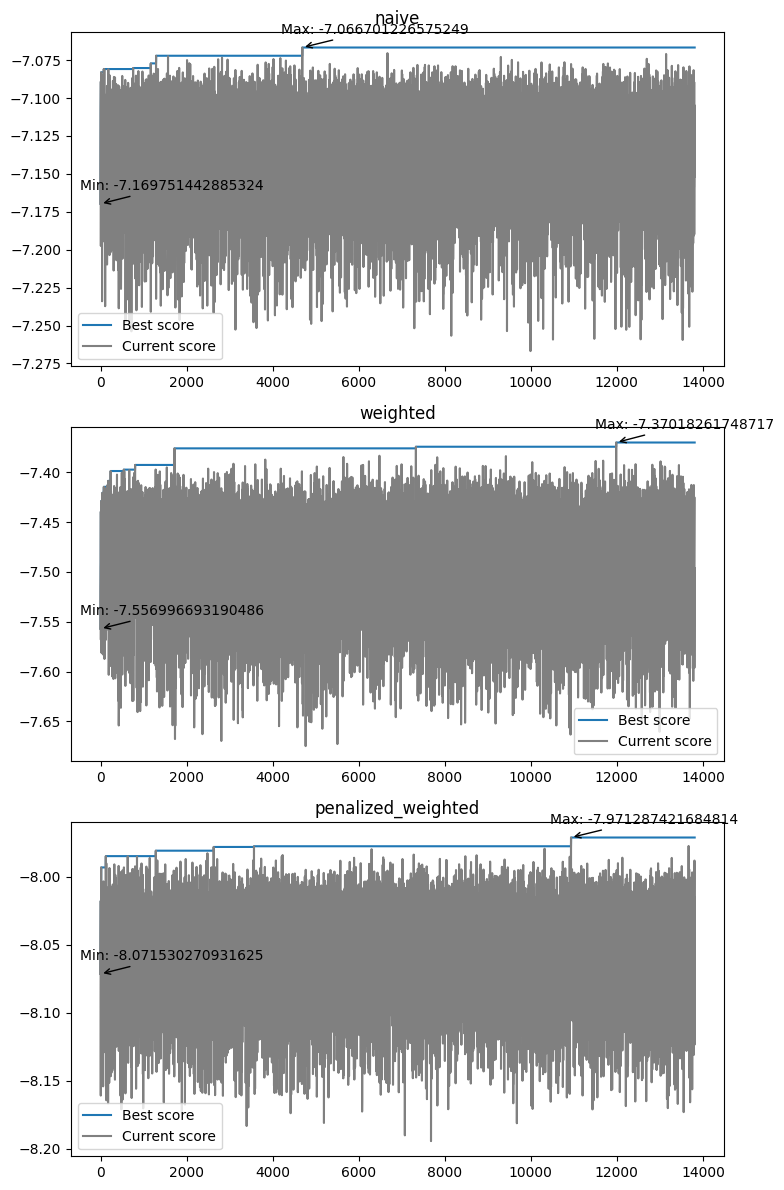

In [66]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(len(eval_data), 1, figsize=(8, len(eval_data) * 4))

for i, (name,data) in enumerate(eval_data.items()):
    x_vals = list(range(1, len(data["best_score_history"]) + 1))
    best_y_vals = data["best_score_history"]
    current_y_vals = data["current_score_history"]

    axs[i].plot(x_vals, best_y_vals, label="Best score")
    axs[i].plot(x_vals, current_y_vals, label="Current score", color="grey")

    min_best, max_best = min(best_y_vals), max(best_y_vals)
    min_curr, max_curr = min(current_y_vals), max(current_y_vals)

    axs[i].annotate(f"Min: {min_best}", xy=(best_y_vals.index(min_best),min_best), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    axs[i].annotate(f"Max: {max_best}", xy=(best_y_vals.index(max_best),max_best), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    #axs[i].annotate(f"Min: {min_curr}", xy=(current_y_vals.index(min_curr), min_curr), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    #axs[i].annotate(f"Min: {max_curr}", xy=(current_y_vals.index(max_curr), max_curr), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))

        # Set title and legend
    axs[i].set_title(name)
    axs[i].legend()

# Show the figure
plt.tight_layout()
plt.show()

In [75]:
eval_data = {}

for name, func in obj_functions:
    sol, score, best_score_history, current_score_history = simulated_annealing_partitioning(
        items=productos,
        n = 8,
        f = productos_weighted_naive_objective_function,
        find_neighbour=adaptive_next_neighbour,
        op=shaker_operator,
        r=5,
        cooling_rate=0.999,
        g=producto_partition_greedy_function,
    )

    eval_data.update({name: {"best_score": score, "best_score_history": best_score_history, "solution": sol, "current_score_history": current_score_history}})

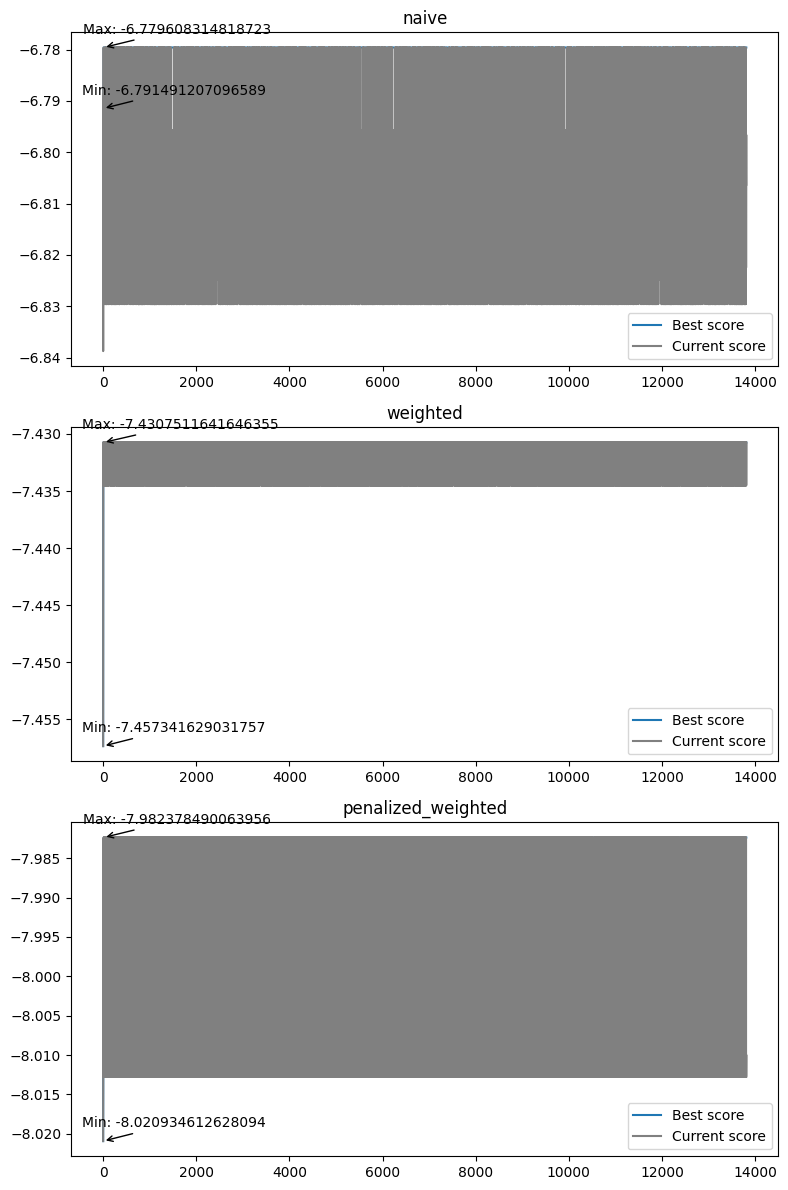

In [76]:
fig, axs = plt.subplots(len(eval_data), 1, figsize=(8, len(eval_data) * 4))

for i, (name,data) in enumerate(eval_data.items()):
    x_vals = list(range(1, len(data["best_score_history"]) + 1))
    best_y_vals = data["best_score_history"]
    current_y_vals = data["current_score_history"]

    axs[i].plot(x_vals, best_y_vals, label="Best score")
    axs[i].plot(x_vals, current_y_vals, label="Current score", color="grey")

    min_best, max_best = min(best_y_vals), max(best_y_vals)
    min_curr, max_curr = min(current_y_vals), max(current_y_vals)

    axs[i].annotate(f"Min: {min_best}", xy=(best_y_vals.index(min_best),min_best), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    axs[i].annotate(f"Max: {max_best}", xy=(best_y_vals.index(max_best),max_best), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    #axs[i].annotate(f"Min: {min_curr}", xy=(current_y_vals.index(min_curr), min_curr), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
    #axs[i].annotate(f"Min: {max_curr}", xy=(current_y_vals.index(max_curr), max_curr), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))

        # Set title and legend
    axs[i].set_title(name)
    axs[i].legend()

# Show the figure
plt.tight_layout()
plt.show()

best score: 21248.0 - current_score: 21248.0 - new_score: 21248.0 - temp: 990.0
best score: 21248.0 - current_score: 21248.0 - new_score: 21248.0 - temp: 980.1
best score: 21248.0 - current_score: 21248.0 - new_score: 21248.0 - temp: 970.299
best score: 21248.0 - current_score: 21248.0 - new_score: 21248.0 - temp: 960.59601
best score: 21248.0 - current_score: 21248.0 - new_score: 21248.0 - temp: 950.9900498999999
best score: 21248.0 - current_score: 21248.0 - new_score: 21248.0 - temp: 941.480149401
best score: 21248.0 - current_score: 21248.0 - new_score: 21248.0 - temp: 932.0653479069899
best score: 21248.0 - current_score: 21248.0 - new_score: 21248.0 - temp: 922.74469442792
best score: 21248.0 - current_score: 21248.0 - new_score: 21248.0 - temp: 913.5172474836407
best score: 21248.0 - current_score: 21248.0 - new_score: 21248.0 - temp: 904.3820750088043
best score: 21248.0 - current_score: 21248.0 - new_score: 21248.0 - temp: 895.3382542587163
best score: 21248.0 - current_score:

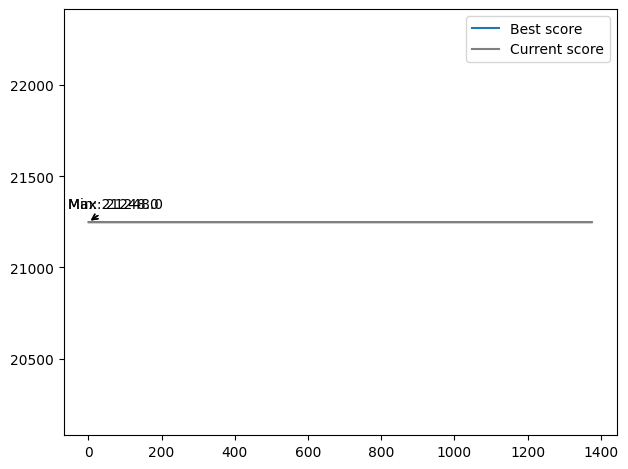

In [92]:
sol, score, best_score_history, current_score_history = simulated_annealing_partitioning(
        items=ferias,
        n = 8,
        f = feria_penalized_objective_function,
        find_neighbour=find_next_best_neighbour,
        op=shaker_operator,
        r=2,
        cooling_rate=0.99,
        debug=True
    )


# Create a figure and axis using plt.subplots()
fig, ax = plt.subplots()

x_vals = list(range(1, len(best_score_history) + 1))
best_y_vals = best_score_history
current_y_vals = current_score_history
ax.plot(x_vals, best_y_vals, label="Best score")
ax.plot(x_vals, current_score_history, label="Current score", color="grey")

    
min_best, max_best = min(best_y_vals), max(best_y_vals)
min_curr, max_curr = min(current_y_vals), max(current_y_vals)

ax.annotate(f"Min: {min_best}", xy=(best_y_vals.index(min_best),min_best), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))
ax.annotate(f"Max: {max_best}", xy=(best_y_vals.index(max_best),max_best), xytext=(-15,10), textcoords="offset points", arrowprops=dict(arrowstyle='->'))

ax.legend()

# Show the figure
plt.tight_layout()
plt.show()

In [42]:
sol.get_partitions(
)[0][0] == Feria(**sol.get_partitions(
)[0][0].__dict__)

True